## BASKET ANALYSIS

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from datetime import date
from datetime import time
import datetime as dt

import mlxtend.frequent_patterns 
import mlxtend.preprocessing

In [37]:
order_detail_df = pd.read_csv("data/order_processed.csv")
user_df = pd.read_csv("data/user_processed.csv")
listening_detail_df = pd.read_csv("data/listening_processed.csv")
clustering_df = pd.read_csv("data/clustering_processed.csv")

#### Xử lý kiểu dữ liệu

In [45]:
##### Đổi tên cột
listening_detail_df.columns=["PlaylistID","Playlist Name","Category","SubCategory","PlaylistType","PlaylistDuration(min)",
                            "ActualDuration(min)","UserID","ListeningTime","ListeningDate","ListeningDatetime"]

In [58]:
listening_detail_df["ListeningDate"] = listening_detail_df["ListeningDate"].astype("datetime64")
listening_detail_df["PlaylistID"] = listening_detail_df["PlaylistID"].astype("object")

In [ ]:
##### Chuyển dữ liệu datetime
order_detail_df["Transaction Date"]=order_detail_df["Transaction Date"].astype("datetime64")

### Function definition

In [ ]:
def visualize_numerical(df, column, target = None):

    fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 4));

    sns.histplot(df[column], ax=ax1, kde=True);
    ax1.set_xlabel(column);
    ax1.set_ylabel('Number');
    ax1.set_title(f'{column}  Distribution');
    
    if(target == None):
        sns.boxplot(y=column, data=df, showmeans=True, ax=ax2);
        ax2.set_ylabel(column);
    else:
        sns.boxplot(x=target, y=column, data=df, showmeans=True, ax=ax2);
        ax2.set_xlabel('Target');
        ax2.set_ylabel(column);
    
    plt.show()

def visualize_numerical_lst(df, numerical = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',\
                            'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], target = None):
    for column in numerical:
        visualize_numerical(df,column, target)
        print();
        
def frequency_items (x,y):
    fx_=sum([x in i for i in my_basket])
    fy_=sum([y in i for i in my_basket])
    
    fxy_=sum([all(z in i for z in [x,y]) for i in my_basket])
    
    support=fxy_/len(my_basket)
    confidence = support/(fx_/len(my_basket))
    lift =confidence /(fy_/len(my_basket))
    if confidence ==1:
        conviction = 0
    else:
        conviction=(1-(fy_/len(my_basket)))/(1-confidence)
    
    print("Support = {}".format(round(support,2)))
    print("Confidence = {}".format(round(confidence,2)))
    print("Lift= {}".format(round(lift,2)))
    print("Conviction={}".format(round(conviction,2)))

def frequency_item(x,df):
    '''
        Return tần suất xuất hiện của item trong các lượt nghe
    '''
    fx_=sum([x in i for i in df])
    support = fx_/len(df)
    return support

### PROCESSING listening_detail_df

1. Drop những playlist có duration ngắn
2. Drop các playlist có frequency quá thấp ==> vẽ phân phối frequency để nhìn thấy các outliers

##### 1. Short duration: drop (q_25)
1. chỉ lấy những lượt nghe có Actual Duration >25% dữ liệu

In [194]:
listening_detail_df["ActualDuration(min)"].describe()

count    750098.000000
mean         15.428639
std          26.597340
min           0.000000
25%           1.300000
50%           7.300000
75%          19.400000
max        1769.600000
Name: ActualDuration(min), dtype: float64

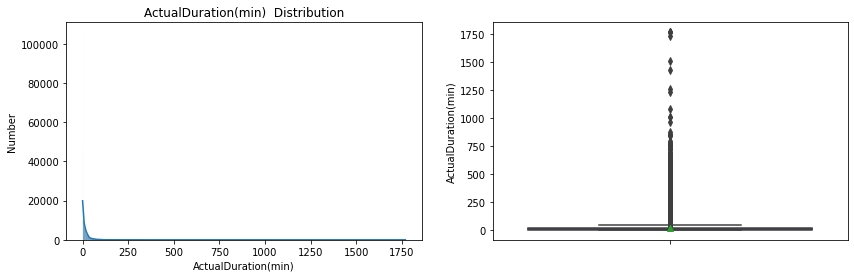

In [199]:
visualize_numerical(listening_detail_df,"ActualDuration(min)")

In [204]:
bk_listening_detail_df = listening_detail_df.copy()
q_25 = listening_detail_df["ActualDuration(min)"].quantile(0.25)

In [210]:
## Drop những lượt nghe có duration ngắn hơn 5'
listening_detail_df = listening_detail_df[listening_detail_df["ActualDuration(min)"]>=5]
listening_detail_df.shape[0]

372887

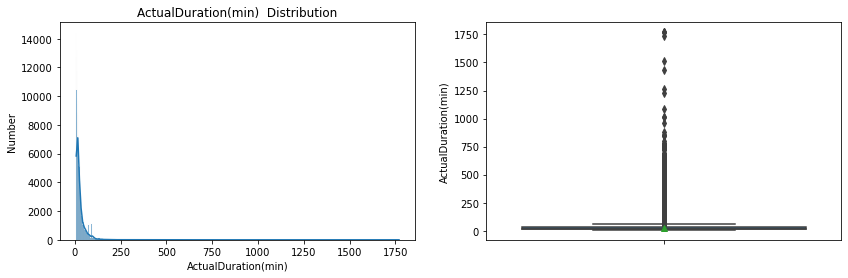

In [211]:
visualize_numerical(listening_detail_df,"ActualDuration(min)")

##### 2. Outliers Frequency:
1. Frequency thấp: Drop những playlist có lượt nghe thấp
<!-- 2. Frequency cao: đưa về mean() -->

In [212]:
### summary theo Playlist

playlist_summary_df = listening_detail_df.groupby("PlaylistID").agg({"ListeningDate":["count"]}).reset_index()
playlist_summary_df.columns=['PlaylistID','listen_cnt']
playlist_summary_df.head(3)

,PlaylistID,listen_cnt
0,3808,297
1,3813,311
2,3814,128


In [222]:
### Tính Frequency cho các playlist:
total_listen_cnt = listening_detail_df.shape[0]
playlist_summary_df['Frequency'] = round(playlist_summary_df.listen_cnt/total_listen_cnt,6)

In [223]:
playlist_summary_df[["listen_cnt",'Frequency']].describe()

,listen_cnt,Frequency
count,1213.000000,1213.000000
mean,307.408904,0.000824
std,1242.264937,0.003331
min,1.000000,0.000003
25%,33.000000,0.000088
50%,105.000000,0.000282
75%,256.000000,0.000687
max,28090.000000,0.075331


In [225]:
playlist_summary_df[['Frequency']].describe(percentiles = [.2,.3,.4,.6,.8])

,Frequency
count,1213.000000
mean,0.000824
std,0.003331
min,0.000003
20%,0.000063
30%,0.000118
40%,0.000201
50%,0.000282
60%,0.000383
80%,0.000828


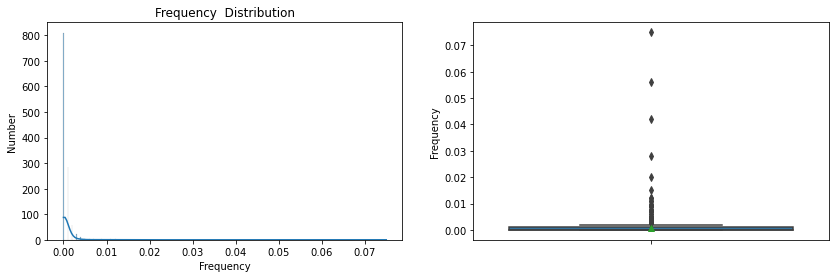

In [215]:
visualize_numerical(playlist_summary_df,"Frequency")

In [227]:
# Drop q_30
q_30 = playlist_summary_df["Frequency"].quantile(0.30)
playlist_summary_df=playlist_summary_df[playlist_summary_df.Frequency>=q_30]

In [229]:
playlist_summary_df[["listen_cnt",'Frequency']].describe()

,listen_cnt,Frequency
count,855.000000,855.000000
mean,429.491228,0.001152
std,1462.707365,0.003923
min,44.000000,0.000118
25%,96.500000,0.000258
50%,177.000000,0.000475
75%,348.000000,0.000933
max,28090.000000,0.075331


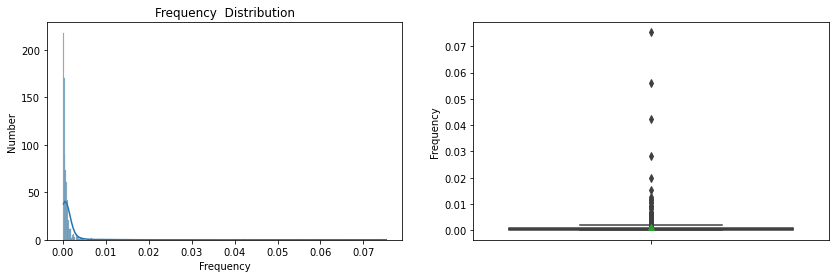

In [228]:
visualize_numerical(playlist_summary_df,"Frequency")

In [231]:
### Lấy lại listening_detail_df sau khi đã xử lý outliers
# is_processed = listening_detail_df["PlaylistID"] in playlist_summary_df.PlaylistID
# listening_detail_df['PlaylistID'].isin(playlist_summary_df.PlaylistID)
listening_detail_df = listening_detail_df[listening_detail_df['PlaylistID'].isin(playlist_summary_df.PlaylistID)]

In [232]:
listening_detail_df.shape[0]

367215

#### Function definitions

In [ ]:
def frequency_items (x,y):
    fx_=sum([x in i for i in my_basket])
    fy_=sum([y in i for i in my_basket])
    
    fxy_=sum([all(z in i for z in [x,y]) for i in my_basket])
    
    support=fxy_/len(my_basket)
    confidence = support/(fx_/len(my_basket))
    lift =confidence /(fy_/len(my_basket))
    if confidence ==1:
        conviction = 0
    else:
        conviction=(1-(fy_/len(my_basket)))/(1-confidence)
    
    print("Support = {}".format(round(support,2)))
    print("Confidence = {}".format(round(confidence,2)))
    print("Lift= {}".format(round(lift,2)))
    print("Conviction={}".format(round(conviction,2)))

def frequency_item(x,df):
    '''
        Return tần suất xuất hiện của item trong các lượt nghe
    '''
    fx_=sum([x in i for i in df])
    support = fx_/len(df)
    return support

### Lấy danh sách các playlists theo transaction

1. Một transaction: danh sách playlits mà users nghe trong vòng 15 ngày
2. playlist_basket: chứa các playlist theo transaction 15 ngày

#### 1. Tính danh sách nghe mỗi 15 ngày của các users
1. Các playlists nằm trong playlist_basket

In [190]:
def get_playlists_in_timewindow(user_id,timewindow = 15 ):
    '''
        Return list of playlists that user listens successively in every period of 15 days
    '''
    user_basket = []
    
    df = listening_detail_df[listening_detail_df["UserID"]==user]
    t_min = df['ListeningDate'].min()
    t_max = df['ListeningDate'].max()

    ### tính số transactions có thể có của mỗi users nếu chia ra 15 ngày là 1 transaction
    distance = (t_max - t_min).days
    div_delta = int(distance/time_window)
    mod_delta = distance%time_window
    div_delta,mod_delta
    trans_cnt = (div_delta+1) if mod_delta > 0 else div_delta

    ### Xác định các mốc thời gian tương ứng
    freq = str(timewindow)+'D'
    date_points = pd.date_range(start =t_min.date(),periods = trans_cnt+1,freq =freq)
    
    ### Tính playlists của các transactions ứng với các date_point ở trên <= <
    for i in range(trans_cnt):
        playlists = df[df.ListeningDate.between(date_points[i], date_points[i+1])]["PlaylistID"].tolist()
        if len(playlists)>0:
            user_basket.append(playlists)
    
    return(user_basket)

In [193]:
### Playlist basket cho cả hệ thống
playlist_basket = []
users = listening_detail_df['UserID'].unique().tolist()
for user in users:
    user_basket = get_playlists_in_timewindow(user)
    playlist_basket += user_basket

KeyboardInterrupt: 

#### Basket Analysis on listening detail

In [ ]:
encode_=mlxtend.preprocessing.TransactionEncoder()
encode_arr=encode_.fit_transform(data)
## 3. Converting to dataframe.

encode_df=pd.DataFrame(encode_arr, columns=encode_.columns_)
encode_df

In [ ]:
## 4. Calculating support.

md=mlxtend.frequent_patterns.apriori(encode_df)
md_minsup=mlxtend.frequent_patterns.apriori(encode_df,
                                           min_support=0.01, 
                                            use_colnames=True)
md_minsup.head(20)

In [ ]:
## 5. Creating rules (Metric: Confidence) Antecedents ⇒ Consequents

rules=mlxtend.frequent_patterns.association_rules(
md_minsup, metric="confidence",min_threshold=0.06,support_only=False)

rules.head(20)

In [ ]:
## 6.Creating rules (Metric: Lift) Antecedents ⇒ Consequents

rules2=mlxtend.frequent_patterns.association_rules(
md_minsup, metric="lift",min_threshold=0.06,support_only=False)

rules2.head(20)

In [ ]:
## 7. Scatter plot
## Scatter plots help us to evaluate general tendencies of rules between antecedents and consequents

import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt 

# Generate scatterplot using support and confidence
plt.figure(figsize=(10,6))
sns.scatterplot(x = "support", y = "confidence", 
                size = "lift", data = rules)
plt.margins(0.01,0.01)
plt.show()

## Conclusion

In this post, we have had a glimpse into what Affinity Analysis is and how to implement it in python.
Affinity Analysis or Market Basket Analysis is used to extract valuable insights from transaction data. It can be used to determine what products to discount. Also, it can increase sales and customer satisfaction. It is important to realize that there are many other areas in which it can be applied.